# Machine learning for risk management


Risks can be market risk (e.g., increase in interest rates), credit risk (e.g., unable to honour debt), operational risk (e.g., inherent operation(s) in a company are bad for sustainability), and liquidity risk( e.g., a company cannot turn its assets into cash within a short period of time)

In [1]:
import yfinance as yfin
import numpy as np 
import pandas as pd 
import pandas_datareader.data as pdr
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


yfin.pdr_override()

# List of stock symbols
ticker = 'MSFT'

# Set the date range for the historical data
start_date = '2015-01-01'
end_date = '2021-01-01'

# Download historical stock data for each stock

stock = pdr.get_data_yahoo(ticker, start_date, end_date,interval='1mo').Close



[*********************100%%**********************]  1 of 1 completed


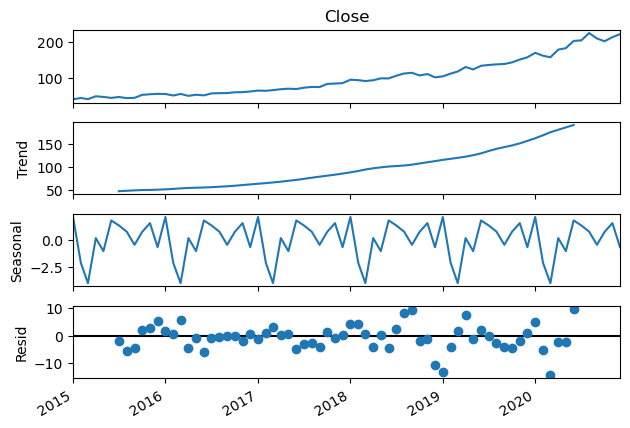

In [112]:
# Plot  the components of a time series by
# seasonal_decompose function from statsmodels
import matplotlib.pyplot as plt

seasonal_decompose(stock, period=12).plot()
plt.gcf().autofmt_xdate()
plt.show()

## ACF and PCF

Auto-correlation functions (ACF) show the correlation between the same series with different lags. With h being the lag:

$ρ(h) = \frac{Cov(X_t , X_{t−h} )}{Var(X_t )}$

The coefficients help in deciding the q in MA(q) models.

Partial ACF (PACF) gives information on correlation between current value of a time series
and its lagged values controlling for the other correlations.

$ρ(h) = \frac{Cov(X_t ,X_{t−h} |X_{t−1} ,X_{t−2} ...X_{t−h−1})}{
\sqrt{Var(X_t |X_{t−1} ,X_{t−2} ,...,X_{t−h−1} )Var(X_{t−h} |X_{t−1} ,X_{t−2} ,...,X_{t−h−1} )}}$

The coefficients help in deciding the p in AR(p) models.


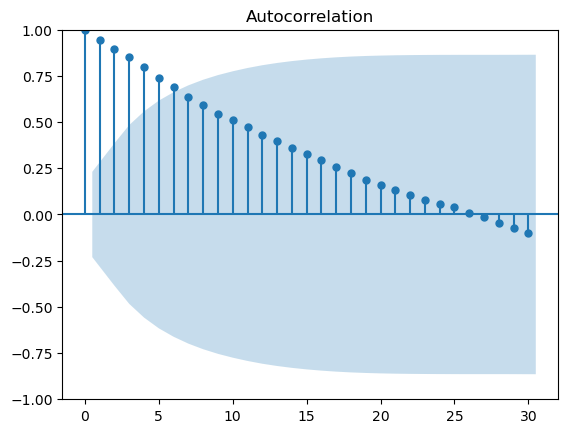

In [113]:
sm.graphics.tsa.plot_acf(stock,lags=30)
plt.show()

It shows that  there is strong dependence between the current value and lagged values of
stock data as the coefficients of autocorrelation decay slowly.

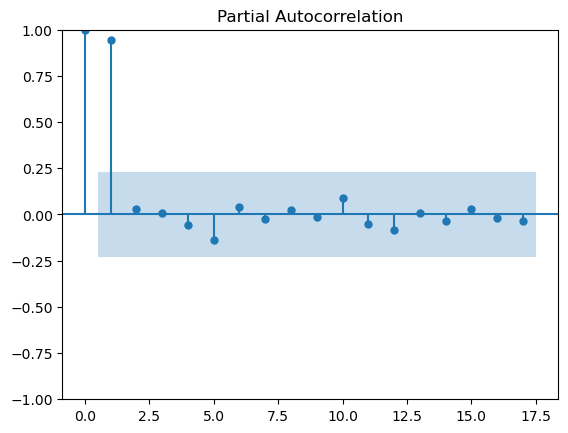

In [114]:
sm.graphics.tsa.plot_pacf(stock, lags=17)
plt.show()

Lines above the confidence intervals are considered significant. We see the model with lag of 2 coefficient is enough to model the variations.

## Time Series modeling

### Moving Average (MA)

Moving average can be considered as smoothing model as it tends to take into account the lag
values of residual.

For $\alpha \ne 0$, MA(q) can be written as:

$X_t = \epsilon_t + \alpha_1 \epsilon_{t−1} + \alpha_2 \epsilon_{t−2} ... + \alpha_q \epsilon_{t−q}$


In [2]:

# choose data over 2 years
start_date = '2019-1-1'
end_date = '2021-1-1'

# get the data with 1d interval 
stocks = pdr.get_data_yahoo(ticker, start_date, end_date,interval='1d').Close
stocks.dropna(inplace=True)
returns = stocks.pct_change()
returns.dropna(inplace=True)
stat_test = adfuller(returns.dropna())[0:2]
print(f"The test statistic and p-value of ADF test are {stat_test}")
if stat_test[1] < 0.05:
    print("The data is stationary")
else:
    print("The data is not stationary")

# split the data into train and test
split = int(len(returns.values) * 0.90)

ticker_train = returns.iloc[:split]
ticker_test = returns.iloc[split:]
print(ticker_test.shape,ticker_train.shape)


[*********************100%%**********************]  1 of 1 completed
The test statistic and p-value of ADF test are (-7.212097179922102, 2.2211435488651752e-10)
The data is stationary
(51,) (453,)


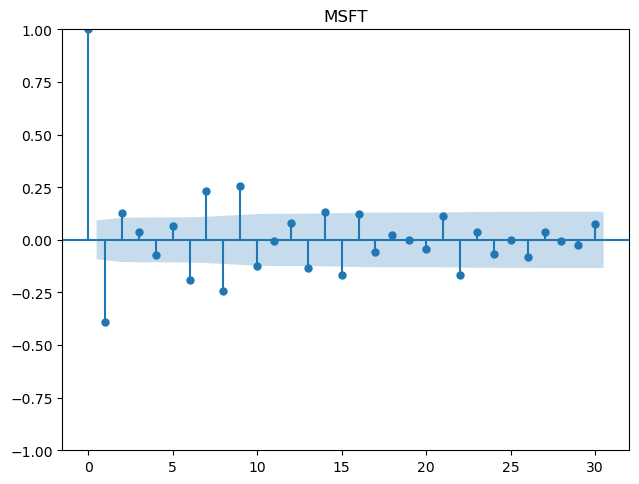

In [121]:
fig, ax = plt.subplots(1, 1)
plt.tight_layout()
sm.graphics.tsa.plot_acf(ticker_train,lags=30, ax=ax, title=f'{ticker}')
plt.show()

Peaks at 9 and 27, we choose them as small and long moving average

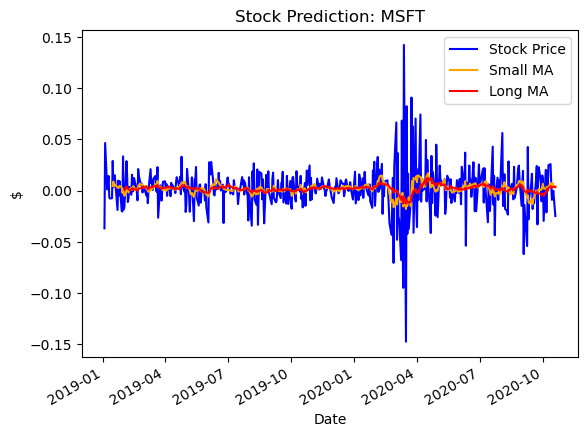

In [122]:
# get small and long moving average
small_ma = ticker_train.rolling(window=9).mean()
long_ma = ticker_train.rolling(window=21).mean()

#plot
fig, ax = plt.subplots(1, 1)
ax.plot(ticker_train.loc[start_date:end_date].index,ticker_train.loc[start_date:end_date],label='Stock Price',c='b')
ax.plot(small_ma.loc[start_date:end_date].index,small_ma.loc[start_date:end_date],
label = 'Small MA',c='orange')
ax.plot(long_ma.loc[start_date:end_date].index,long_ma.loc[start_date:end_date],
label = 'Long MA',c='r')
ax.legend(loc='best')
ax.set_ylabel('$')
ax.set_xlabel('Date')
ax.set_title(f'Stock Prediction: {ticker}')
plt.gcf().autofmt_xdate()
plt.show()

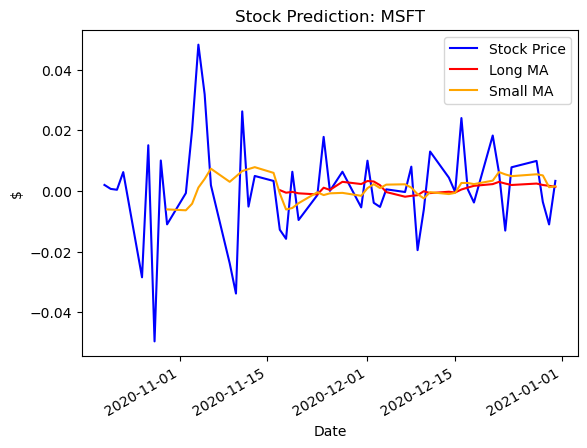

In [123]:
# get small and long moving average
small_ma = ticker_test.rolling(window=9).mean()
long_ma = ticker_test.rolling(window=21).mean()

#plot
fig, ax = plt.subplots(1, 1)
ax.plot(ticker_test.loc[start_date:end_date].index,ticker_test.loc[start_date:end_date],label='Stock Price',c='b')
ax.plot(long_ma.loc[start_date:end_date].index,long_ma.loc[start_date:end_date],
label = 'Long MA',c='r')
ax.plot(small_ma.loc[start_date:end_date].index,small_ma.loc[start_date:end_date],
label = 'Small MA',c='orange')

ax.legend(loc='best')
ax.set_ylabel('$')
ax.set_xlabel('Date')
ax.set_title(f'Stock Prediction: {ticker}')
plt.gcf().autofmt_xdate()
plt.show()

Short-term moving average tends to more reactive to daily activity and long MA captures the global trend, But still the model is not able to capture the trends

### Autoregressive Model

Idea is the current value is regressed over its own lag
values in this model. Forcast the current value of time series $X_{t}$:


$X_t = c + \alpha_1 X_{t−1} + \alpha_2 X_{t−2} ... + \alpha_p X_{t−p} + \epsilon_t$



We see a peak in the PCAF of data at p=22

In [169]:
from statsmodels.tsa.ar_model import AutoReg

ar_ticker = AutoReg(ticker_train.values, lags=22)
ar_fitted_ticker = ar_ticker.fit()

ar_predictions_ticker = ar_fitted_ticker.predict(start=len(ticker_train.values),end=len(ticker_train.values)+len(ticker_test.values)-1,dynamic=False)


# convert to DataFrame
ar_predictions_ticker = pd.DataFrame(ar_predictions_ticker)
ar_predictions_ticker.index = ticker_test.index

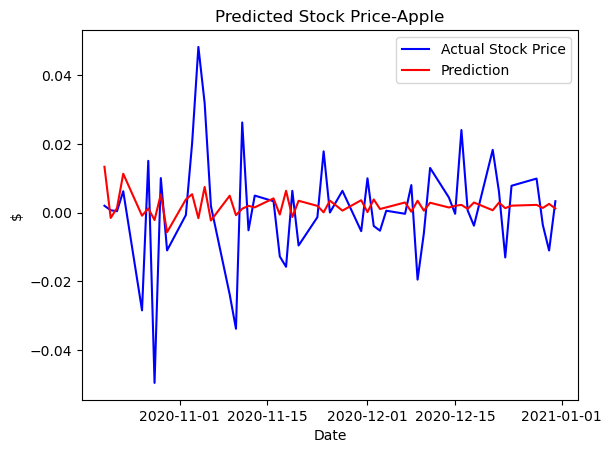

In [170]:
fig, ax = plt.subplots()
ax.plot(ticker_test, label='Actual Stock Price', c='b')
ax.plot(ar_predictions_ticker, c='r', label="Prediction")
ax.set_title('Predicted Stock Price-Apple')
ax.legend(loc='best')
ax.set(xlabel='Date', ylabel='$')
plt.show()

AR model does a marginally better job than MA at predicting the stock trend but still is not able to predict it to good affect.

### ARIMA Models

ARIMA models are a combination of three key components: AutoRegressive (AR), Integrated (I), and Moving Average (MA). The advantage of intergration parameter is that is non-stationary data is used it can make it stationary by defining the integration parameter. 

Three parameters are to be defined p (dicussed above for AR), q (dicussed for MA) and d (control for level difference). d=1 is makes the model ARMA which is a limiting case of ARIMA (p,1,q) models but is also a good model given by:

$Xt = \alpha_1 dX_{t−1} + \alpha_2 dX_{t−2} ... + \alpha_p dX_{t−p} + \epsilon_t + \beta_1 d\epsilon_{t−1} + \beta_2 d\epsilon_{t−2} ... + \beta_q d\epsilon_{t−q}$

Pros
 - ARIMA allows us to work with raw data without considering if it is
stationary.
 - It performs well with high-frequent data.
It is less sensitive to the fluctuation in the data compared to other models.

Cons
 - ARIMA might fail in capturing seasonality.
 - It work better with a long series and short-term (daily, hourly) data.
 - As no automatic updating occurs in ARIMA, no structural break during the analysis period should be observed.
 - Having no adjustment in the ARIMA process leads to instability.


In [1]:
from statsmodels.tsa.arima.model import ARIMA
import itertools
import warnings
import yfinance as yfin
import numpy as np 
import pandas as pd 
import pandas_datareader.data as pdr
import statsmodels.api as sm
import matplotlib.pyplot as plt

yfin.pdr_override()

# To ignore all warnings:
warnings.filterwarnings("ignore")
ticker = 'MSFT'

# choose data over 2 years
start_date = '2019-1-1'
end_date = '2021-1-1'

# get the data with 1d interval 
stocks = pdr.get_data_yahoo(ticker, start_date, end_date,interval='1mo').Close
stocks.dropna(inplace=True)

# split the data into train and test
split = int(len(stocks.values) * 0.66)

ticker_train = stocks.iloc[:split]
ticker_test = stocks.iloc[split:]


[*********************100%%**********************]  1 of 1 completed


Choosing the parameters from for the ARIMA model. I choose the range 0-10 for the p and q and 0-3 for d.
Selection of the parameters for the model is made using Akaike Information Criterion (AIC). The parameters resulting in minimum value of AIC are selected. 

$AIC=2k−2ln(L)$

Where:
 - AIC is the Akaike Information Criterion.
 - k is the number of parameters in the model.
 - ln(L) is the natural logarithm of the likelihood of the model.




In [2]:

# setup the parameter ranges to explore
p =range(0, 10)
q = range(0, 10)
d = range(0, 3)

# get combinations of parameters in a list
pdq = list(itertools.product(p, d, q))

# container for results
arima_results_ticker = pd.DataFrame(np.nan*np.zeros(len(pdq)),columns=['AIC'])


# loop through parameters
for i,param_set in enumerate(pdq):
    try:
        arima_ticker = ARIMA(ticker_train, order=param_set)
        arima_fitted_ticker = arima_ticker.fit()
        arima_results_ticker['AIC'].iloc[i] = arima_fitted_ticker.aic
    except:
        continue



finding the minimum AIC and the parameters

In [3]:
print(arima_results_ticker.where(arima_results_ticker.T.notnull().all()).min()[0])
print(pdq[arima_results_ticker['AIC'].idxmin()])

90.56961371642562
(9, 2, 1)


The (p,d,q) that gives minimum value of AIC is (9,2,1)

In [4]:
arima_ticker = ARIMA(ticker_train, order=pdq[arima_results_ticker['AIC'].idxmin()])
arima_fitted_ticker = arima_ticker.fit()

In [5]:
# ARIMA predictions
arima_predictions_ticker = arima_fitted_ticker.predict(start=len(ticker_train.values),end=len(ticker_train.values)+len(ticker_test.values)-1,dynamic=False)

# convert to DataFrame
arima_predictions_ticker = pd.DataFrame(arima_predictions_ticker)
arima_predictions_ticker.index = ticker_test.index

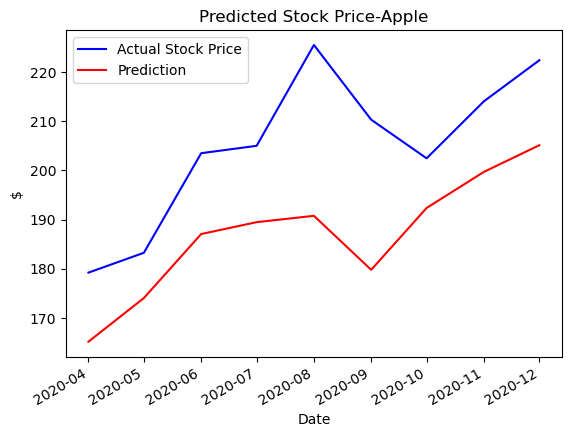

In [6]:
# plot the predictions

fig, ax = plt.subplots()
ax.plot(ticker_test, label='Actual Stock Price', c='b')
ax.plot(arima_predictions_ticker, c='r', label="Prediction")
ax.set_title('Predicted Stock Price-Apple')
ax.legend(loc='best')
ax.set(xlabel='Date', ylabel='$')
plt.gcf().autofmt_xdate()

plt.show()

The ARIMA model is able to get capture the trend of the price movement. Although the exact prices have a shift.